In [34]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Part I. Modelling
## Loading and Preparing Data

In [37]:
# Load data
df = pd.read_csv("../data/athens_q3.csv")

In [38]:
# Missing values calculation
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum() > 0]

In [39]:
count_missing_values(df)

description                       303
neighborhood_overview            6379
host_location                    4252
host_about                       7003
host_response_time               1461
host_response_rate               1461
host_acceptance_rate              711
host_is_superhost                 925
host_neighbourhood               8256
neighbourhood                    6379
neighbourhood_group_cleansed    14137
bathrooms                         440
bathrooms_text                     19
bedrooms                           61
beds                              456
price                             427
calendar_updated                14137
has_availability                   55
first_review                     1858
last_review                      1858
review_scores_rating             1858
review_scores_accuracy           1858
review_scores_cleanliness        1858
review_scores_checkin            1858
review_scores_communication      1858
review_scores_location           1858
review_score

In [40]:
# We focus on normal apartments, n<8
df = df.loc[lambda x: x["accommodates"] < 8]

In [41]:
# Basic statistics 
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.359900e+04,1.359900e+04,1.359900e+04,13599.000000,13599.000000,0.0,13599.000000,13599.000000,13599.000000,13174.000000,...,11795.000000,11795.000000,11795.000000,11795.000000,11795.000000,13599.000000,13599.000000,13599.000000,13599.000000,11795.000000
mean,5.947929e+17,2.024092e+13,2.528435e+08,27.732260,38.811457,NaN,37.980045,23.731628,3.436723,1.146652,...,4.769060,4.857285,4.854976,4.684994,4.723310,13.517832,12.478491,0.937716,0.033017,1.810473
std,4.946901e+17,5.906467e+00,1.963025e+08,94.523635,181.267622,NaN,0.013415,0.012444,1.381206,0.561024,...,0.386886,0.295466,0.335856,0.434325,0.395479,21.861888,21.577641,4.242868,0.474390,1.792152
min,1.099000e+04,2.024092e+13,1.805000e+03,1.000000,1.000000,NaN,37.950322,23.701280,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,3.939362e+07,2.024092e+13,7.004271e+07,2.000000,2.000000,NaN,37.968946,23.723961,2.000000,1.000000,...,4.710000,4.840000,4.850000,4.580000,4.670000,1.000000,1.000000,0.000000,0.000000,0.460000
50%,7.601029e+17,2.024092e+13,2.043019e+08,6.000000,7.000000,NaN,37.978476,23.729631,4.000000,1.000000,...,4.890000,4.940000,4.950000,4.820000,4.820000,4.000000,3.000000,0.000000,0.000000,1.170000
75%,1.060710e+18,2.024092e+13,4.566140e+08,22.000000,26.000000,NaN,37.987947,23.737565,4.000000,1.000000,...,5.000000,5.000000,5.000000,4.970000,4.940000,16.000000,14.000000,0.000000,0.000000,2.680000
max,1.250702e+18,2.024092e+13,6.532905e+08,2983.000000,7294.000000,NaN,38.030830,23.780220,7.000000,48.500000,...,5.000000,5.000000,5.000000,5.000000,5.000000,124.000000,124.000000,40.000000,9.000000,15.330000


In [42]:
# Basic statistics of target variable (price)
df.price.describe()

count      13187
unique       473
top       $60.00
freq         363
Name: price, dtype: object

### The format of price variable is changed later 

In [44]:
# Different types of rooms
df.room_type.value_counts()

room_type
Entire home/apt    12469
Private room        1006
Hotel room            72
Shared room           52
Name: count, dtype: int64

In [45]:
# Different types of property
df.property_type.value_counts()

property_type
Entire rental unit                    8740
Entire condo                          2862
Private room in rental unit            417
Entire home                            318
Entire serviced apartment              257
Room in hotel                          213
Entire loft                            131
Private room in condo                  114
Room in aparthotel                     102
Room in boutique hotel                  79
Private room in serviced apartment      41
Room in serviced apartment              38
Private room in home                    38
Private room in bed and breakfast       27
Shared room in hostel                   26
Private room in guest suite             20
Entire townhouse                        20
Private room in guesthouse              18
Private room in hostel                  16
Tiny home                               16
Entire vacation home                    16
Entire guesthouse                       11
Entire guest suite                      

In [46]:
# Number of reviews
df.number_of_reviews.value_counts()

number_of_reviews
0      1804
1       914
2       700
3       565
4       444
       ... 
515       1
636       1
457       1
454       1
464       1
Name: count, Length: 523, dtype: int64

## Feature Engineering

In [12]:
def feature_engineering(df):
    # Basic cleaning
    df = df.dropna(subset=['price'])  # Drop rows where price is missing
    df['price'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True).astype(float)  # Change the format of the price variable 

    # Feature Engineering (extracting number of amenities)
    df['num_amenities'] = df['amenities'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

    # Extract amenities as explicit dummy columns
    amenities_list = ['Air conditioning', 'Smoking allowed', 
                      'Pets allowed', 'Free parking on premises']
    for amenity in amenities_list:
        df[amenity] = df['amenities'].apply(lambda x: 1 if isinstance(x, str) and amenity in x else 0)

    # Basic Variables
    basic_vars = [
        "accommodates",
        "bedrooms",
        "beds",
        "minimum_nights",
        "maximum_nights",
        "property_type",
        "room_type",
        "bathrooms",
        "num_amenities"
    ]

    # Reviews
    reviews = [
        "number_of_reviews",
        "number_of_reviews_ltm",
        "review_scores_rating",
        "review_scores_value",
        "reviews_per_month"
    ]

    # Combine predictors and target variable
    predictors = basic_vars + reviews + amenities_list 
    df = df[predictors + ['price']]  # Include target variable 'price'

    return df

### Variable selection:
### *accommodates* captures the size of the property in terms of the number of people it can host, which can affect the price.
### *bedrooms*, *beds*, and *bathrooms* are likely to correlate with the size and comfort of the property, thus impacting price.
### *property_type* and *room_type* categorize the type of accommodation, which influences how much people are willing to pay for a stay.
### Review Variables: The *number of reviews* and *ratings* provide useful information about the quality of the property. Higher-rated properties or those with more reviews may have higher prices due to higher demand or quality.
### Amenities: The presence of certain amenities like *air conditioning*, *free parking*, *allowance of smoking* and the *allowance of pets* can make properties more attractive and increase the price. Including them as binary features allows the model to learn how these specific amenities affect the price.

### Feature Engineering:
### Missing Values Handling: The decision to drop rows where the price is missing ensures that the model won't be trained on incomplete data. 
### Amenities Count (num_amenities): By counting the number of amenities listed, we create a simple yet informative feature that summarizes how well-equipped a property is. This feature captures the idea that properties with more amenities are generally more expensive.
### Dummy Variables for Amenities: By creating binary features for specific important amenities like air conditioning and parking, we allow the model to learn whether these factors directly influence the price. 

In [13]:
df = feature_engineering(df)

/var/folders/rt/ht2w66yn71737qv5l2n9w4s00000gn/T/ipykernel_1940/1173305148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True).astype(float)  # Change the format of the price variable
/var/folders/rt/ht2w66yn71737qv5l2n9w4s00000gn/T/ipykernel_1940/1173305148.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_amenities'] = df['amenities'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
/var/folders/rt/ht2w66yn71737

## Train and Split Dataset

In [47]:
# Train-test split: 80% - train, 20% - test
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_test.shape

((10549, 18), (2638, 18))

In [16]:
# Categorizing the columns 
numeric_cols = ["accommodates", "bedrooms", "beds", "minimum_nights", "maximum_nights", "bathrooms", "num_amenities", 
                "number_of_reviews", "number_of_reviews_ltm", "review_scores_rating", "review_scores_value", "reviews_per_month"]
categorical_cols = ["property_type", "room_type"]

## Imputation of missing values

In [17]:
# Impute missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

# Convert categorical variables to dummy variables
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

### Imputation Strategy:
### Numeric Columns: The choice of using the median for numeric columns is practical, especially in cases where the data may have outliers that could skew the mean. The median is more robust in this case, helping to maintain the integrity of the dataset without introducing bias due to extreme values.
### Categorical Columns: For categorical variables, imputing missing values with the most frequent category is a common approach. The assumption is that the missing data is likely to belong to the most common category. For example, if most properties are of a certain room type (e.g., "Entire home"), it makes sense to impute missing values with that category.

### One-Hot Encoding of Categorical Variables:
### Algorithms like linear regression cannot process categorical variables directly. One-hot encoding (dummy variables) transforms these categorical variables into binary columns that indicate the presence of a specific category.

In [18]:
X_train.shape, X_test.shape

((10549, 60), (2638, 50))

In [19]:
# Ensure both sets have the same features
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [20]:
X_train.shape, X_test.shape

((10549, 60), (2638, 60))

## Modelling

In [28]:
# Define models
models = {
    "OLS": LinearRegression(),
    "LASSO": LassoCV(cv=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

### XGBoost model is chosen as the fifth model.

In [29]:
# Train and evaluate models
results = []
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    elapsed_time = time.time() - start_time
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results.append([name, rmse, r2, elapsed_time])

/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate t

In [30]:
# Create results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²", "Time (s)"])
print(results_df)

               Model        RMSE        R²  Time (s)
0                OLS  136.519938  0.057557  0.064759
1              LASSO  138.291516  0.032939  0.143359
2      Random Forest  139.991546  0.009017  3.836041
3  Gradient Boosting  138.971085  0.023411  0.886765
4            XGBoost  138.365679  0.031902  0.122175


### Overall Performance: All models have relatively low R² values, which suggests that none of them are performing particularly well in explaining the variance of the target variable (price). This could be due to the features not being highly predictive or the model needing further tuning. Additionally, the low R² could indicate a high level of noise in the data, or that the target variable is influenced by factors not captured in the features.
### Model Comparison:
### **OLS** was the fastest but also had the highest performance in terms of R², as was not expected for a simple linear model.
### **LASSO** added regularization, which slightly increased RMSE and further decreased R² compared to OLS, possibly due to underfitting.
### **Random Forest** was the worst in terms of R² and the time taken.
### **Gradient Boosting** performed better than Random Forest. However, these models are more complex and have the potential to perform better with hyperparameter tuning or feature engineering.
### **XGBoost** was the second fastest and showed better performance than Gradient Boosting, although its R² was also low.
### Computation Time: Models like OLS, XGBoost, and LASSO offer reasonable computation times, while Random Forest is significantly slower.

## Feature Importance Comparison 

In [31]:
# Feature importance comparison for RF and Gradient Boosting
rf_importance = models['Random Forest'].feature_importances_
boosting_importance = models['Gradient Boosting'].feature_importances_
feature_names = X_train.columns

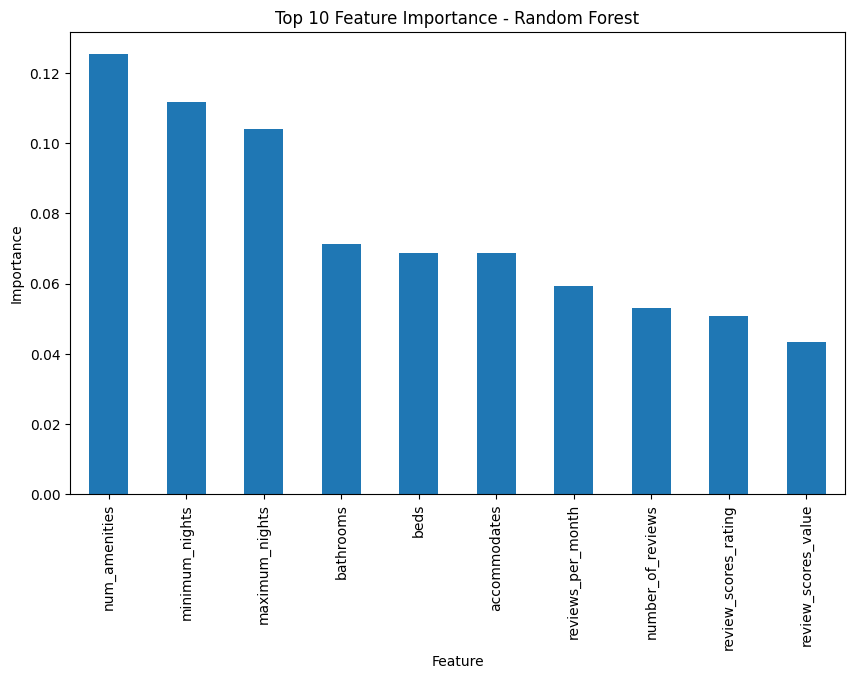

Top 10 Random Forest Features:
                      Importance
Feature                         
num_amenities           0.125436
minimum_nights          0.111814
maximum_nights          0.104022
bathrooms               0.071400
beds                    0.068618
accommodates            0.068583
reviews_per_month       0.059255
number_of_reviews       0.053033
review_scores_rating    0.050790
review_scores_value     0.043338


In [32]:
# Create DataFrame for RF feature importance
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance
}).set_index('Feature')

# Sort by importance and get the top 10
rf_top_features = rf_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot Random Forest feature importance
plt.figure(figsize=(10, 6))
rf_top_features['Importance'].plot(kind='bar')
plt.title("Top 10 Feature Importance - Random Forest")
plt.ylabel("Importance")
plt.show()

# Print the top 10 important features for RF
print("Top 10 Random Forest Features:")
print(rf_top_features)


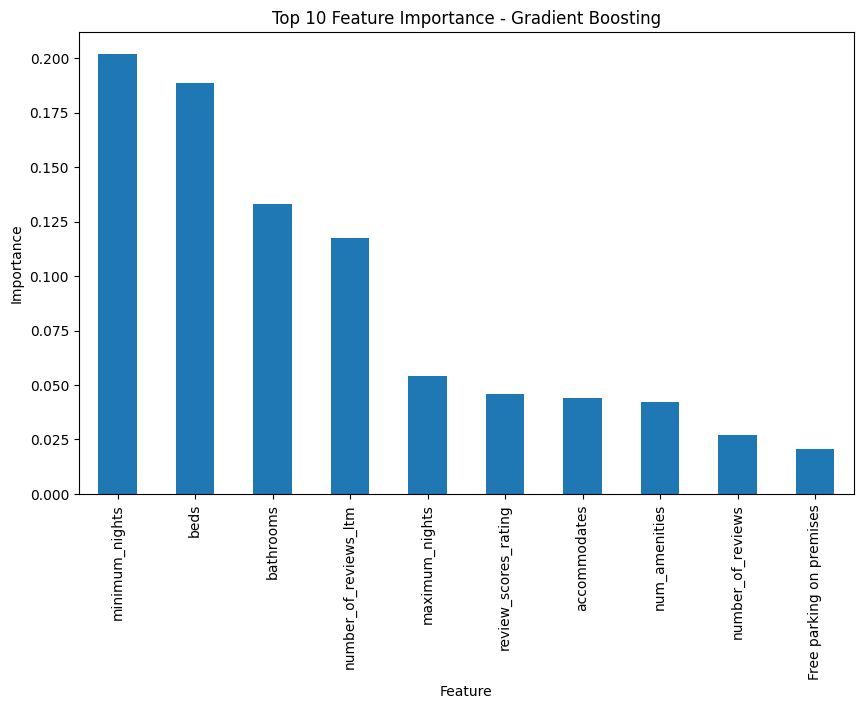

Top 10 Gradient Boosting Features:
                          Importance
Feature                             
minimum_nights              0.201900
beds                        0.188562
bathrooms                   0.132987
number_of_reviews_ltm       0.117317
maximum_nights              0.053930
review_scores_rating        0.045968
accommodates                0.043854
num_amenities               0.042382
number_of_reviews           0.026879
Free parking on premises    0.020767


In [33]:
# Create DataFrame for Gradient Boosting feature importance
boosting_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': boosting_importance
}).set_index('Feature')

# Sort by importance and get the top 10
boosting_top_features = boosting_importance.sort_values(by='Importance', ascending=False).head(10)

# Plot Gradient Boosting feature importance
plt.figure(figsize=(10, 6))
boosting_top_features['Importance'].plot(kind='bar')
plt.title("Top 10 Feature Importance - Gradient Boosting")
plt.ylabel("Importance")
plt.show()

# Print the top 10 important features for Gradient Boosting
print("Top 10 Gradient Boosting Features:")
print(boosting_top_features)


### For Random Forest, minimum_nights ranks 2nd, while for Gradient Boosting, it ranks 1st with the highest importance score.
### This indicates that minimum_nights is highly influential in both models, with Gradient Boosting giving it more weight. This may suggest that the number of minimum nights required to book a listing plays a significant role in determining the price.

### Beds ranks 5th in Random Forest and 2nd in Gradient Boosting, showing that Gradient Boosting places a higher importance on this feature. More beds likely indicate a larger or more luxurious property, thus influencing the price more heavily.

### Both models agree that bathrooms are quite important, ranking 4th in Random Forest and 3rd in Gradient Boosting. This makes sense, as properties with more bathrooms tend to be larger and more expensive.

### Number_of_reviews appears in the top 10 features for both models, though its rank is slightly lower in Gradient Boosting. The number of reviews can be an indirect signal of a property’s popularity, which could affect its pricing.

### Num_amenities ranks 1st in Random Forest but 8th in Gradient Boosting, suggesting that Random Forest places a higher emphasis on the availability of amenities as a key factor in the price. This could indicate that amenities are a strong differentiator in pricing according to the Random Forest model.

### Accommodates ranks highly in both models (6th in Random Forest and 7th in Gradient Boosting). This is expected, as the number of people a property can accommodate typically correlates with its size and, consequently, its price.

### Reviews_per_month is included in the top 10 features for Random Forest, but it does not appear in Gradient Boosting’s top 10. This could suggest that reviews per month, while potentially informative, are less crucial for determining price according to Gradient Boosting.

### In the Gradient Boosting model, Free parking on premises (a specific feature) is included in the top 10, indicating that having parking available significantly impacts price.
### However, this feature doesn't appear in the Random Forest model's top 10.

# Part II. Validity

## Later data

In [309]:
# Load data
df_later = pd.read_csv("../data/athens_q4.csv")

In [310]:
# Feature engineering
df_later = feature_engineering(df_later)

In [311]:
# Splitting the target variable from data for prediction
X = df_later.drop(columns=['price'])
y = df_later['price']

In [312]:
# Impute missing values using imputer of train data
X[numeric_cols] = num_imputer.transform(X[numeric_cols])

X[categorical_cols] = cat_imputer.transform(X[categorical_cols])

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [313]:
X.shape

(13722, 60)

In [314]:
# Ensure both sets have the same features
X = X.reindex(columns=X_train.columns, fill_value=0)

In [316]:
# Train and evaluate models
results = []
for name, model in models.items():
    start_time = time.time()
    y_pred = model.predict(X)
    elapsed_time = time.time() - start_time
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    results.append([name, rmse, r2, elapsed_time])

In [317]:
# Create results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²", "Time (s)"])
print(results_df)

               Model        RMSE        R²  Time (s)
0                OLS  302.854484  0.023803  0.006144
1              LASSO  304.747538  0.011561  0.006336
2      Random Forest  292.993759  0.086336  0.222526
3  Gradient Boosting  298.716422  0.050297  0.016221
4            XGBoost  292.735924  0.087944  0.021863


### Linear models struggle with new data: Linear models (OLS and LASSO) showed a significant drop in performance on the later dataset compared to the earlier test set. This suggests that the later dataset may contain different patterns or non-linear complexities that the linear models are not able to generalize well to.
### Non-linear models: Random Forest, Gradient Boosting and XGBoost performed better than the linear models, with XGBoost being the best performer. It is interesting to note that these models performed better than in the earlier test set in terms of R² values. This highlights the importance of using non-linear models when dealing with complex, real-world datasets where relationships between features and target variables may not be linear.

## Another city = Thessaloniki

In [319]:
# Load data
df_thessaloniki = pd.read_csv("../data/thessaloniki_q3.csv")

In [320]:
# Feature engineering
df_thessaloniki = feature_engineering(df_thessaloniki)

In [321]:
# Splitting the target variable from data for prediction
X = df_thessaloniki.drop(columns=['price'])
y = df_thessaloniki['price']

In [322]:
# Impute missing values using imputer of train data
X[numeric_cols] = num_imputer.transform(X[numeric_cols])

X[categorical_cols] = cat_imputer.transform(X[categorical_cols])

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [323]:
X.shape

(4284, 48)

In [324]:
# Ensure both sets have the same features
X = X.reindex(columns=X_train.columns, fill_value=0)

In [325]:
# Train and evaluate models
results = []
for name, model in models.items():
    start_time = time.time()
    y_pred = model.predict(X)
    elapsed_time = time.time() - start_time
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    results.append([name, rmse, r2, elapsed_time])

In [326]:
# Create results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²", "Time (s)"])
print(results_df)

               Model        RMSE        R²  Time (s)
0                OLS   67.587813 -0.150650  0.008926
1              LASSO   68.776331 -0.191473  0.004431
2      Random Forest  106.288157 -1.845614  0.085292
3  Gradient Boosting   91.939803 -1.129185  0.004898
4            XGBoost  112.750707 -2.202173  0.020331


### The R² values on the Thessaloniki dataset are all negative, with XGBoost showing the lowest R² of -2.2022. This suggests that none of the models can explain any variance in the price data for Thessaloniki, which could be a result of the dataset’s different characteristics or complexities. 

## Conclusion
### The created models are not well-trained for valid generalization across different time and regions. While the models perform better on the initial test dataset, their performance significantly deteriorates when evaluated on new or "live" data, such as the later date and Thessaloniki city. This suggests that the models are not suited for external validation. 